In [1]:
import sys
sys.path.append("../..")
import lib.data as data
import lib.haar_wawelet_method.gradients as grad
import numpy as np
import lib.haar_wawelet_method.util as ut
from lib.mesurements import mse

from lib.haar_wawelet_method import haar

In [14]:
import numpy as np
import lib.haar_wawelet_method.gradients as grad
import lib.data as data
import matplotlib.pyplot as plt
import lib.mesurements
import lib.haar_wawelet_method.haar as haar
%matplotlib inline

$\lambda_k = \frac{4}{h^2}\sin^{2}(\frac{kh}{2})$

In [15]:
def get_lamda (N,h):
    return np.array([4 / h**2 * np.sin(k * h / 2)**2 for k in range (N)])

$\mu_k = 1 - \frac{h^2}{6}\lambda_k$

In [16]:
def get_mu (N,h):
    return 1 - h**2 / 6 * get_lamda(N,h)

In [17]:
def create_L(dim):
    diag1 = np.array([2 if i == j else 0 for i in range (dim) for j in range(dim)]).reshape(dim,dim)
    diag2 = np.array([-1 if np.abs(i - j) == 1 else 0 for i in range (dim) for j in range(dim)]).reshape(dim,dim)
    return diag1 + diag2

In [18]:
def create_B(dim):
    return np.eye(dim) - 1 / 6 * create_L(dim)
create_B(3)

array([[0.66666667, 0.16666667, 0.        ],
       [0.16666667, 0.66666667, 0.16666667],
       [0.        , 0.16666667, 0.66666667]])

In [19]:
def create_G1(dim):
    diag1 = np.array([-1 if i - j == -1 else 0 for i in range (dim) for j in range(dim)]).reshape(dim,dim)
    diag2 = np.array([1 if i - j == 1 else 0 for i in range (dim) for j in range(dim)]).reshape(dim,dim)
    return 0.5 * (diag1 + diag2)

create_G1(3)

array([[ 0. , -0.5,  0. ],
       [ 0.5,  0. , -0.5],
       [ 0. ,  0.5,  0. ]])

In [20]:
def create_G2(dim):
    return create_G1(dim).T

добавить выбросы?

In [21]:
def get_F(g1, g2, h):
    size = g1.shape[0]
    mat1 = np.dot(create_G1(size)/h, g1)
    F1 = np.dot(mat1, create_B(size))
    mat2 = np.dot(create_B(size), g2)/h
    F2 = np.dot(mat2, create_G2(size))
#вариант 3
#     mat1 = np.dot(create_G1(size)/h, g1)
#     F1 = np.dot(create_B(size), mat1)
#     mat2 = np.dot(create_G2(size), g2)/h
#     F2 = np.dot(create_B(size), mat2)
    return F1 + F2

Почему-то если умножать так $G_1g_1B + Bg_2G_2$ то метод работает для функций $x^{2k+1} + y^{2k+1}$

In [52]:
def super_gauss(x, y, a, N):
    return np.exp(-((x**2 + y**2) / a**2) ** N)
    #return np.exp(-((x**2 + y**2) / 2.88 * np.pi) ** 10)

def disk(x, y, r):
    return x ** 2 + y ** 2 < r ** 2

In [53]:
def method(g1, g2, alfa, gamma, h):
    f = np.fft.fft2(get_F(g1, g2, h))
    #f = np.fft.fft2(np.conj(f))
    #cдвиг
    #f = np.fft.fftshift(f)
    lamda = get_lamda(f.shape[0], h)
    mu = get_mu(f.shape[0], h)
    res = np.zeros(f.shape, dtype=complex)
    for k in range(res.shape[0]):
        for l in range(res.shape[1]):
            res[k,l] = (lamda[k]*mu[l] + mu[k]*lamda[l] + alfa * mu[k]*mu[l] + gamma * lamda[k]*lamda[l])
    #res = np.fft.ifftshift(res)
    res = np.fft.ifft2(f/res)
    return np.real(res)
    
    #return np.real(np.fft.ifft2((np.conj(res))))


какими брать g1, g2?
делать ли преобразование фурье?


2.143075555297929e-05
0.00013146909804626075


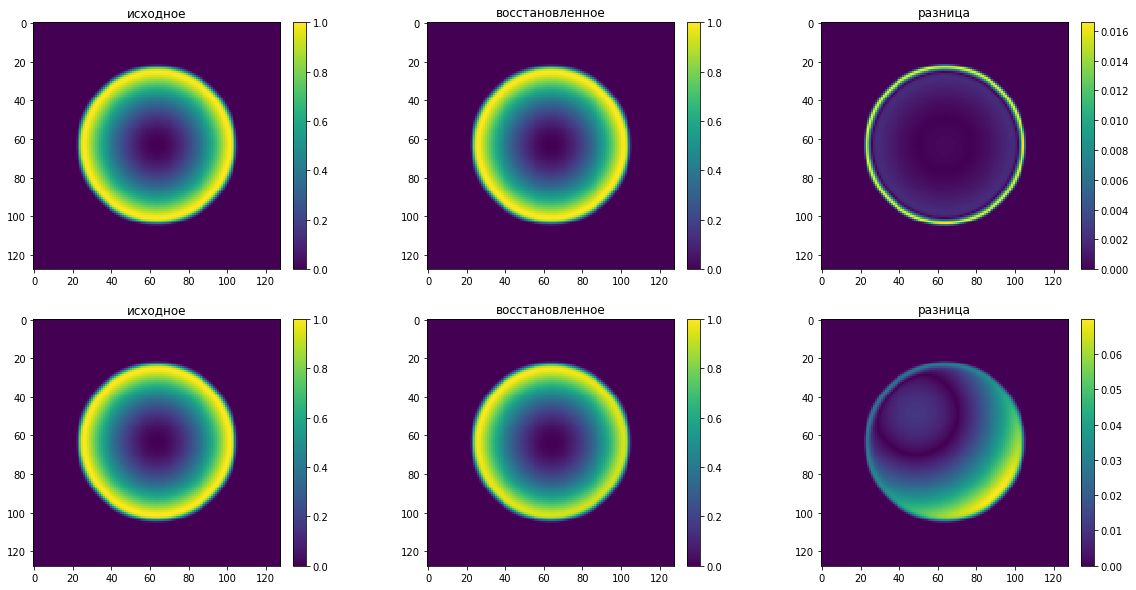

In [63]:
M = 7
#должно быть не так так ! исправь баг!
y, x = data.get_plane(-np.pi, np.pi, -np.pi, np.pi, M)

#y, x = data.get_plane(0, 2 * np.pi, 0, 2 * np.pi, M)
h = 2*np.pi / 2**M
im = x ** 2 + y ** 2
gauss = super_gauss(x, y, 2, 20)
im *= gauss
g1, g2 = 2 * x,  2 * y
g1 *= gauss
g2 *= gauss

#g2 , g1= grad.fried_model_gradient(im)
#g1 /= h
#g2 /= h

fig, axes = plt.subplots(2,3, figsize = (20,10))
restored = method(g1,g2, 3 * 10**(-9), 0, h)
#нормировка исходного
im -= im.min()
im /= im.max()
#нормировка полученного
restored -= restored.min()
restored *= gauss
restored /= restored.max()


img1 = axes[0][0].imshow(im)
img2 = axes[0][1].imshow(restored)
img3 = axes[0][2].imshow((np.abs(im - restored)) * disk(x, y, 3))
axes[0][0].set_title('исходное')
axes[0][1].set_title('восстановленное')
axes[0][2].set_title('разница')
fig.colorbar(img1, ax = axes[0,0],fraction=0.046, pad=0.04)
fig.colorbar(img2, ax = axes[0,1],fraction=0.046, pad=0.04)
fig.colorbar(img3, ax = axes[0,2],fraction=0.046, pad=0.04)
#fig.savefig('variational_very_bad.png')

fried = g2 * h, g1 * h
hudgin = g2 * h, g1 * h
LH, HL, HH = haar.analyze(fried[0], fried[1], hudgin[0], hudgin[1])
LL = {0: np.array([[1.0]])}
LL = haar.syntesis(LL, LH, HL, HH, M)
restored_haar = LL[M]
restored_haar -= restored_haar.min()
restored_haar *= gauss
restored_haar /= restored_haar.max()
img1 = axes[1][0].imshow(im)
img2 = axes[1][1].imshow(restored_haar)
img3 = axes[1][2].imshow(np.abs(im - restored_haar))
axes[1][0].set_title('исходное')
axes[1][1].set_title('восстановленное')
axes[1][2].set_title('разница')
fig.colorbar(img1, ax = axes[1,0],fraction=0.046, pad=0.04)
fig.colorbar(img2, ax = axes[1,1],fraction=0.046, pad=0.04)
fig.colorbar(img3, ax = axes[1,2],fraction=0.046, pad=0.04)
fig.savefig('../../ExperimentResults/HaarVsVariational/')
print(mse(im, restored))
print(mse(im, restored_haar))

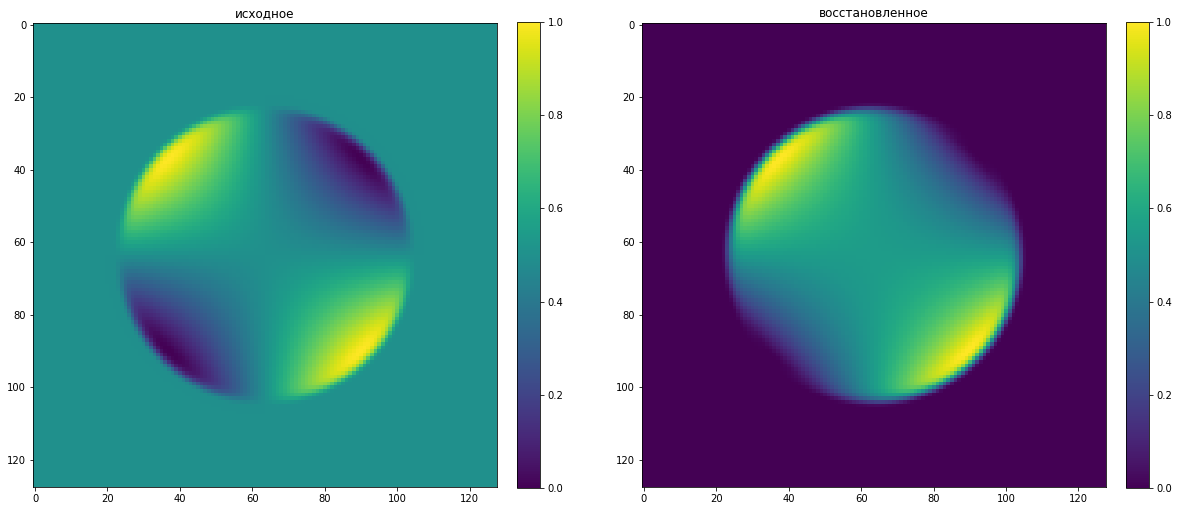

In [27]:
M = 7
#должно быть так ! исправь баг!
y, x = data.get_plane(-np.pi, np.pi, -np.pi, np.pi, M)

#y, x = data.get_plane(0, 2 * np.pi, 0, 2 * np.pi, M)
h = 2*np.pi / 2**M
im = x * y
gauss = super_gauss(x, y, 2, 20)
im *= gauss
g1, g2 = y,  x
g1 *= gauss
g2 *= gauss

# g1, g2 = grad.Hudgin_gradien_model(im)
# g1 /= h
# g2 /= h

fig, axes = plt.subplots(1,2, figsize = (20,10))
restored = method(g1,g2, 2, 0.001, h)
#нормировка исходного
im -= im.min()
im /= im.max()
#нормировка полученного
restored -= restored.min()
restored *= gauss
restored /= restored.max()

img1 = axes[0].imshow(im)
img2 = axes[1].imshow((restored))
axes[0].set_title('исходное')
axes[1].set_title('восстановленное')
fig.colorbar(img1, ax = axes[0],fraction=0.046, pad=0.04)
fig.colorbar(img2, ax = axes[1],fraction=0.046, pad=0.04)
#fig.savefig('variational_very_bad.png')

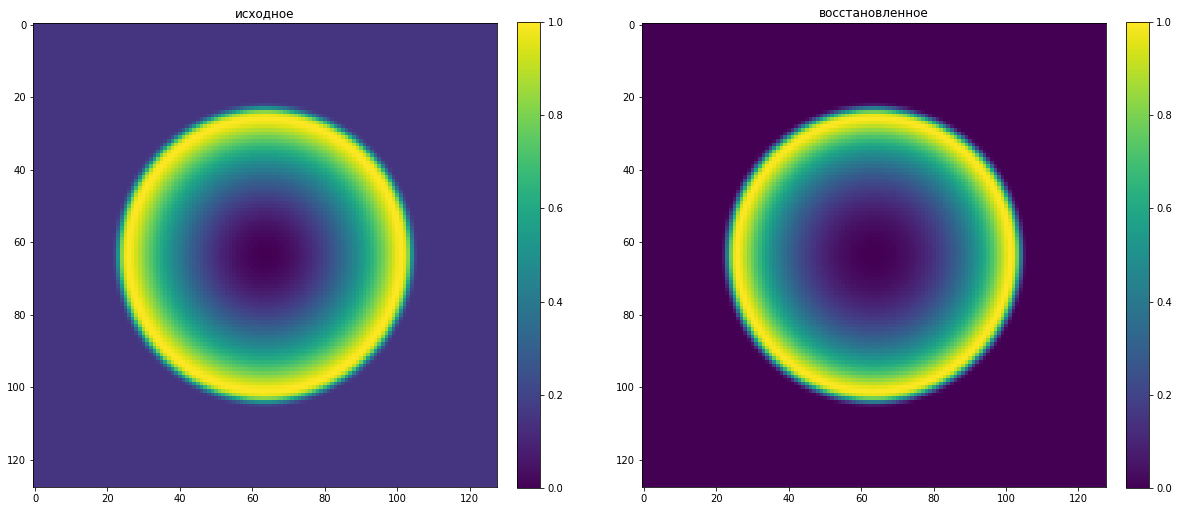

In [23]:
M = 7
#должно быть так ! исправь баг!
y, x = data.get_plane(-np.pi, np.pi, -np.pi, np.pi, M)

#y, x = data.get_plane(0, 2 * np.pi, 0, 2 * np.pi, M)
h = 2*np.pi / 2**M
im = 2*(x**2 + y**2) - 1
gauss = super_gauss(x, y, 2, 20)
im *= gauss
g1, g2 = 4*x,  4*y
g1 *= gauss
g2 *= gauss

# g1, g2 = grad.Hudgin_gradien_model(im)
# g1 /= h
# g2 /= h

fig, axes = plt.subplots(1,2, figsize = (20,10))
restored = method(g1,g2, 2, 0.001, h)
#нормировка исходного
im -= im.min()
im /= im.max()
#нормировка полученного
restored -= restored.min()
restored *= gauss
restored /= restored.max()

img1 = axes[0].imshow(im)
img2 = axes[1].imshow((restored))
axes[0].set_title('исходное')
axes[1].set_title('восстановленное')
fig.colorbar(img1, ax = axes[0],fraction=0.046, pad=0.04)
fig.colorbar(img2, ax = axes[1],fraction=0.046, pad=0.04)
#fig.savefig('variational_very_bad.png')

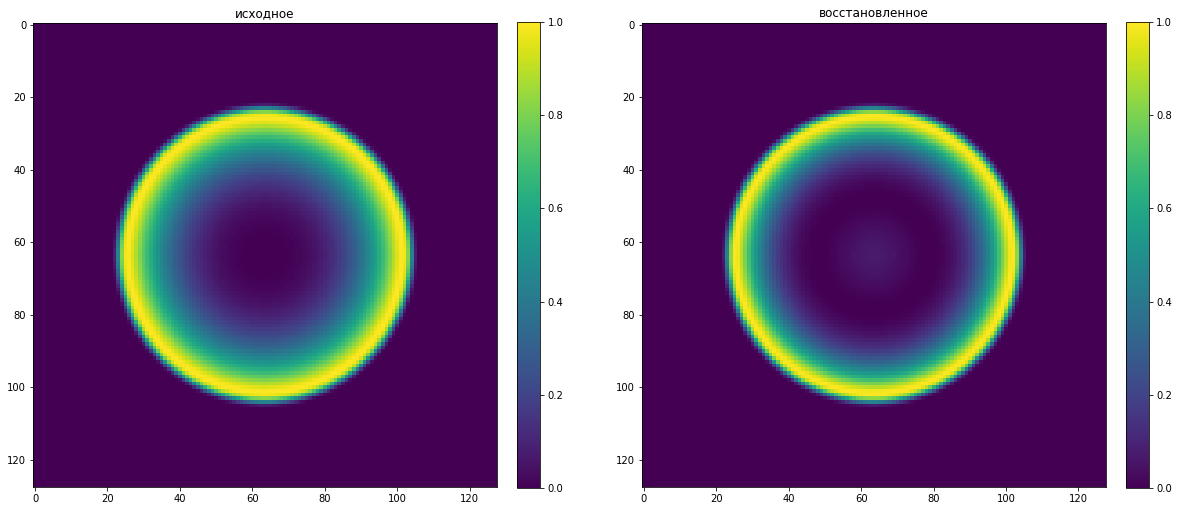

In [24]:
M = 7
#должно быть так ! исправь баг!
y, x = data.get_plane(-np.pi, np.pi, -np.pi, np.pi, M)

#y, x = data.get_plane(0, 2 * np.pi, 0, 2 * np.pi, M)
h = 2*np.pi / 2**M
im = (x**2 + y**2)*np.sqrt(x**2 + y**2)
gauss = super_gauss(x, y, 2, 20)
im *= gauss
g1 = 2*x*np.sqrt(x**2 + y**2) + x**3/(np.sqrt(x**2 + y**2)) + x*y**2/np.sqrt(x**2 + y**2)
g2 = 2*y*np.sqrt(x**2 + y**2) + y**3/(np.sqrt(x**2 + y**2)) + y*x**2/np.sqrt(x**2 + y**2)
g1 *= gauss
g2 *= gauss

# g1, g2 = grad.Hudgin_gradien_model(im)
# g1 /= h
# g2 /= h

fig, axes = plt.subplots(1,2, figsize = (20,10))
restored = method(g1,g2, 2, 0.001, h)
#нормировка исходного
im -= im.min()
im /= im.max()
#нормировка полученного
restored -= restored.min()
restored *= gauss
restored /= restored.max()

img1 = axes[0].imshow(im)
img2 = axes[1].imshow((restored))
axes[0].set_title('исходное')
axes[1].set_title('восстановленное')
fig.colorbar(img1, ax = axes[0],fraction=0.046, pad=0.04)
fig.colorbar(img2, ax = axes[1],fraction=0.046, pad=0.04)
#fig.savefig('variational_very_bad.png')